In [1]:
# configuration parameters for Times square
last_data_date = 'Now'
duration_in_day = 5

In [2]:
from matplotlib import pyplot as plt

from lsst_efd_client import EfdClient,resample
import numpy as np
import pandas as pd
import datetime 
import pytz
timezone = pytz.utc
from math import isnan
import asyncio


In [3]:
# initialisation from 
if last_data_date == 'Now':
    last_data_date_val = datetime.datetime.now(datetime.UTC)
else:
    last_data_date_val = datetime.datetime.fromisoformat(last_data_date+'T14:00:00+00:00')
first_data_date_val = last_data_date_val - datetime.timedelta(days=duration_in_day)
#
tstart=first_data_date_val.isoformat()
tend=last_data_date_val.isoformat()
# save plot on file
save_fig=False
# show plot on screen 
show_it = True
#
day_ref=datetime.datetime.fromisoformat(tstart).replace(tzinfo=None)
print( 'we will analyse data between ',tstart,' and ',tend,' using FES configuration at ', day_ref)
run_cur='%s_%s' % (first_data_date_val.isoformat(),last_data_date_val.isoformat())
#
# ------------- initialisation 
# --- Manual configuration  ( to be edited by hand )  
#
#
output_data='/home/a/antilog/public_html/LsstCam/fes/'
#
# --- Automated configuration 
client = EfdClient('usdf_efd')
#
if save_fig  :
    print('Output will be saved in %s%s' % (output_data,run_cur))
#---------
manual=False
#
socket_name=[]
for i in range(5) : 
    socket_name.append('socket%d' % (i+1))
#


we will analyse data between  2026-01-17T00:16:05.528106+00:00  and  2026-01-22T00:16:05.528106+00:00  using FES configuration at  2026-01-17 00:16:05.528106


In [4]:
#
def SaveFig(fig,File,run_cur='',raft_cur='',ccd_cur='',hdu=''):
    if len(hdu)==0 : 
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur)
    else : 
        hdu_cur='%s' % (hdu)
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur,hdu_cur)
    # 
    PlotFile=File.replace('.','_')
    PlotFile=PlotFile.replace(' ','_')
    os.makedirs(root_plt,exist_ok=True)
    plotfile=os.path.join(root_plt,PlotFile)
    print ('PlotFile=',plotfile)
    fig.savefig(plotfile,bbox_inches='tight')
    plt.close(fig) 
    return


In [5]:
async def read_db(query,verbose=False,clean=True) :
    if verbose : print(query)
    db_in =  await client.influx_client.query(query)
    for col in db_in.columns :
        len_col=len(db_in[db_in[col].notnull()])
        if clean :
            if len_col==0 : 
                db_in.drop(columns=[col],inplace=True)
                txt='dropped'
            else :
                txt='kept'
        else :
            txt='kept'  
        if verbose : print('%s (%s) = %d ' % (col,txt,len_col) )
    return db_in 

In [6]:
#========= fill the DB for unlock data 
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs' AND "Canbus"='canbus0' AND ("Controller"='latchXminusController' OR "Controller"='latchXplusController' OR "Controller"='acTruckXminusController' OR "Controller"='acTruckXplusController' OR "Controller"='onlineClampXminusController' OR "Controller"='onlineClampXplusController' OR "Controller"='onlineClampYminusController') AND "Hardware"='autochanger' ''' % (tstart,tend)
controler_ac  = await read_db(query)
#========= fill the DB for unlock data 
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs' AND "Canbus"='canbus0' AND ("Controller"='clampXminusController'  OR "Controller"='clampXplusController' OR "Controller"='carouselController' ) AND "Hardware"='carousel' ''' % (tstart,tend)
controler_car  = await read_db(query)


In [7]:
controler_car

,Agent,Canbus,Controller,Hardware,averageCurrent,brakeActivated,current,errorHistoryNB,errorRegister,followingError,...,lastErrorName,mode,position,positionSensorType,profileAcceleration,profileDeceleration,profileVelocity,state,timestamp,velocity
2026-01-17 00:16:07.878000+00:00,fcs,canbus0,carouselController,carousel,0,True,0,0.0,NO ERROR,0,...,No Error,PROFILE_POSITION,3324556,516.0,2000.0,2000.0,3400.0,SWITCH_ON_DISABLED,1768608967878,0
2026-01-17 00:16:07.879000+00:00,fcs,canbus0,clampXminusController,carousel,0,False,0,0.0,NO ERROR,0,...,No Error,CURRENT,716,NaN,0.0,0.0,0.0,SWITCH_ON_DISABLED,1768608967879,0
2026-01-17 00:16:07.879000+00:00,fcs,canbus0,clampXplusController,carousel,0,False,0,0.0,NO ERROR,0,...,No Error,CURRENT,3501,NaN,0.0,0.0,0.0,SWITCH_ON_DISABLED,1768608967879,0
2026-01-17 00:16:17.878000+00:00,fcs,canbus0,carouselController,carousel,0,True,0,0.0,NO ERROR,0,...,No Error,PROFILE_POSITION,3324556,516.0,2000.0,2000.0,3400.0,SWITCH_ON_DISABLED,1768608977878,0
2026-01-17 00:16:17.879000+00:00,fcs,canbus0,clampXminusController,carousel,0,False,0,0.0,NO ERROR,0,...,No Error,CURRENT,716,NaN,0.0,0.0,0.0,SWITCH_ON_DISABLED,1768608977879,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-21 02:51:49.254000+00:00,fcs,canbus0,clampXminusController,carousel,0,False,0,0.0,NO ERROR,0,...,No Error,CURRENT,772,NaN,0.0,0.0,0.0,SWITCH_ON_DISABLED,1768963909254,0
2026-01-21 02:51:49.254000+00:00,fcs,canbus0,clampXplusController,carousel,0,False,0,0.0,NO ERROR,0,...,No Error,CURRENT,4375,NaN,0.0,0.0,0.0,SWITCH_ON_DISABLED,1768963909254,0
2026-01-21 02:51:49.473000+00:00,fcs,canbus0,carouselController,carousel,0,True,0,0.0,NO ERROR,0,...,No Error,PROFILE_POSITION,3324557,516.0,2000.0,2000.0,3400.0,SWITCH_ON_DISABLED,1768963909473,0
2026-01-21 02:51:49.474000+00:00,fcs,canbus0,clampXminusController,carousel,0,False,0,0.0,NO ERROR,0,...,No Error,CURRENT,772,NaN,0.0,0.0,0.0,SWITCH_ON_DISABLED,1768963909474,0


In [14]:
def MotorPlot(controler_motor,control,current) :
    AutoChanger=['acTruckXminusController','acTruckXplusController','onlineClampXminusController','onlineClampXplusController','onlineClampYminusController','latchXminusController','latchXplusController']
    Carousel=['carouselController','clampXminusController','clampXplusController']
    nx1=['latchXminusController','latchXplusController']
    nx2=['clampXminusController','clampXplusController']
    for controle in control :
        if controle in Carousel : 
            hardware='Carousel'
        elif controle in AutoChanger : 
            hardware='AutoChanger'
        else : 
            print('What is it ? Error !') 
            break 
        print('\n',hardware,' ',controle,'\n')
        if controle in nx1 :
            fig=plt.figure(figsize=(5,5))
            sel_brake=False
            ny=1
            nx=1
        elif controle in nx2 :
            fig=plt.figure(figsize=(10,5))
            sel_brake=False
            ny=1
            nx=2
        else :
            sel_brake=True
            fig=plt.figure(figsize=(15,10))
            ny=2
            nx=3
        if controle == 'carouselController' :
            cont=controler_motor[(controler_motor['Controller']==controle) & (controler_car['positionSensorType']==520.0) & ( controler_car['profileVelocity'] > 2000 )	]
        else : 
            cont=controler_motor[(controler_motor['Controller']==controle) ]
        #=== build related time information  
        brake=cont['state'].to_numpy()
        if len(brake)==0 : continue
        index_brakeOff_i=np.argwhere( (brake[0:-1]=='SWITCH_ON_DISABLED') & (brake[1:]!='SWITCH_ON_DISABLED' ))[:,0]
        if len(index_brakeOff_i) == 0 : continue
        start_controler=cont.iloc[index_brakeOff_i].index
        index_brakeOn_i=np.argwhere( (brake[index_brakeOff_i[0]:-1]!='SWITCH_ON_DISABLED') & (brake[index_brakeOff_i[0]+1:]=='SWITCH_ON_DISABLED' ))[:,0]+index_brakeOff_i[0]+1
        end_controler=cont.iloc[index_brakeOn_i].index
        delta=end_controler-start_controler
        deltas=np.array(delta.seconds)
        good_dur=np.argwhere((deltas!=0))[:,0]
        start=cont.iloc[index_brakeOff_i[good_dur]].index
        end=cont.iloc[index_brakeOn_i[good_dur]].index
        title='%s Controler %s operation  \n for a period from %s to %s UTC \n  ' % (hardware,controle,tstart,tend)
        fig.suptitle(title)
        if sel_brake : 
            xcont=cont[cont['brakeActivated']==False]
        else: 
            xcont=cont 
        plt.subplot(ny,nx,1,title=' %s vs time ' % (current) )
        for i in range(len(start)) :        
             plt.plot((xcont.loc[start[i]:end[i]].index-start[i]).total_seconds(),xcont.loc[start[i]:end[i]][current])    
        plt.xlabel('time since start in s ')
        plt.ylabel('current in mA')  
        if nx >1 : 
            plt.subplot(ny,nx,2,title=' speed vs %s' % (current))
            for i in range(len(start)) : 
                plt.plot(xcont.loc[start[i]:end[i]][current],xcont.loc[start[i]:end[i]]['velocity'])
            plt.xlabel('current in mA')
            plt.ylabel('velocity')
        if nx >2 : 
            plt.subplot(ny,nx,3,title=' position vs %s' % (current))
            for i in range(len(start)) : 
                plt.plot(xcont.loc[start[i]:end[i]][current],xcont.loc[start[i]:end[i]]['position'])
            plt.xlabel('current in mA')
            plt.ylabel('position in micron')
            plt.subplot(ny,nx,4,title=' position vs velocity')
            for i in range(len(start)) : 
                plt.plot(xcont.loc[start[i]:end[i]]['velocity'],xcont.loc[start[i]:end[i]]['position'])
            plt.xlabel('velocity')
            plt.ylabel('position in micron')  
            plt.subplot(ny,nx,5,title=' position vs time '  )
            for i in range(len(start)) :        
                 plt.plot((xcont.loc[start[i]:end[i]].index-start[i]).total_seconds(),xcont.loc[start[i]:end[i]]['position'])    
            plt.xlabel('time since start in s ')
            plt.ylabel('position in micron')  
            plt.subplot(ny,nx,6,title=' followingError vs position'  )
            for i in range(len(start)) :        
                plt.plot(xcont.loc[start[i]:end[i]]['position'],xcont.loc[start[i]:end[i]]['followingError'])
            plt.xlabel('position in micron ')
            plt.ylabel('following error in micron')  

        if show_it : plt.show()
        if save_fig : SaveFig(fig,File=controle,run_cur=run_cur,raft_cur=hardware)


 AutoChanger   acTruckXminusController 



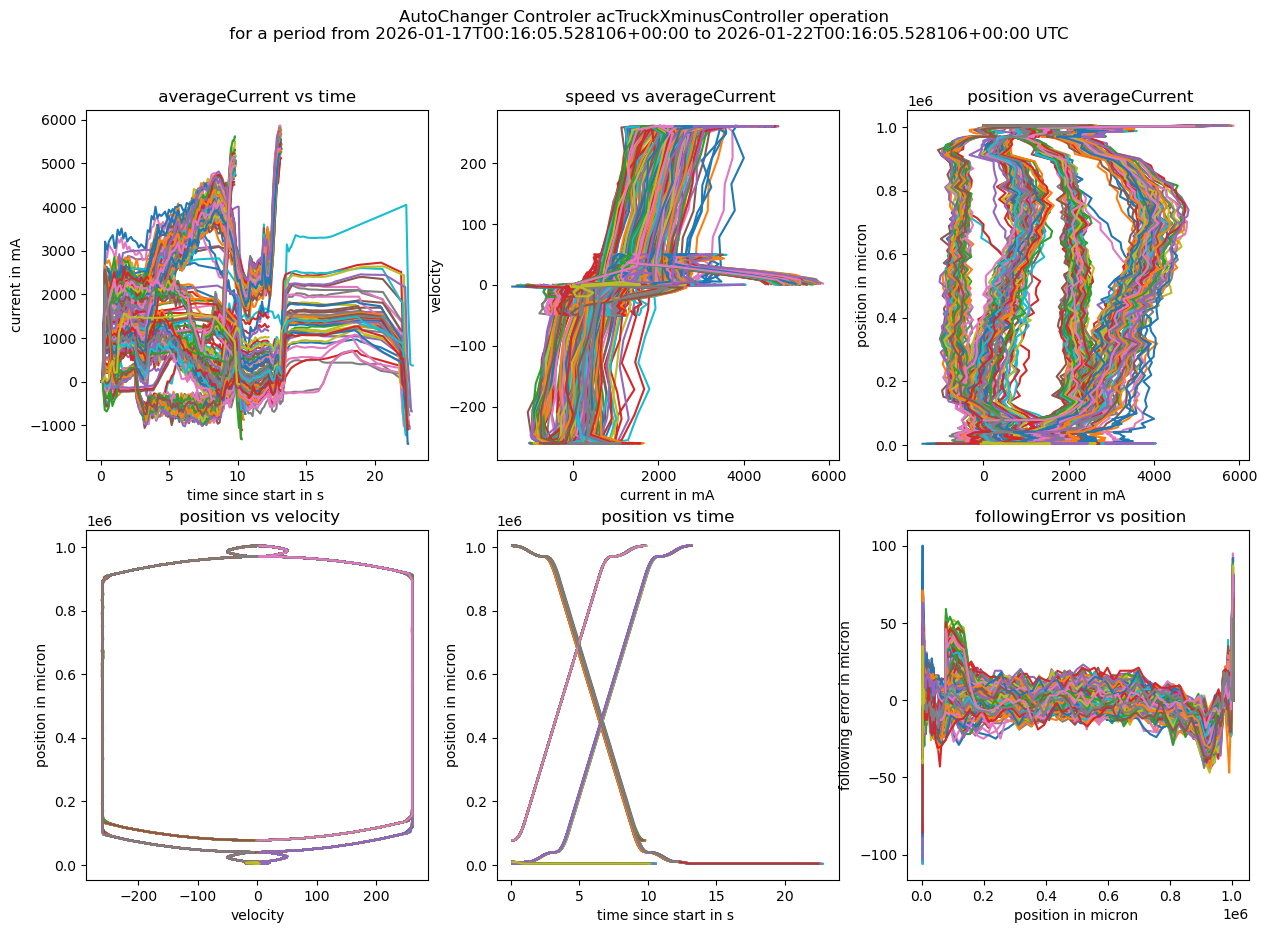


 AutoChanger   acTruckXplusController 



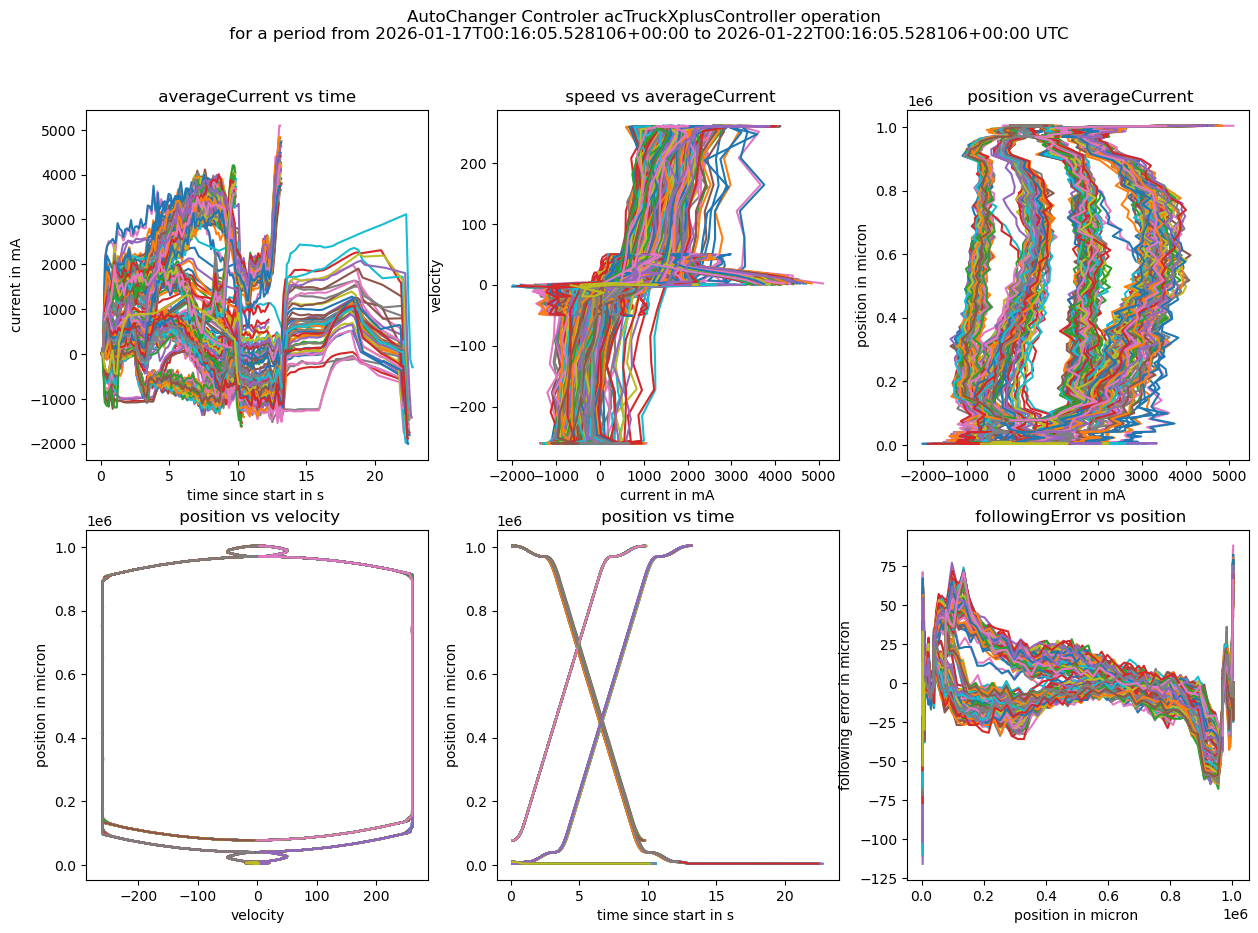


 AutoChanger   onlineClampXminusController 



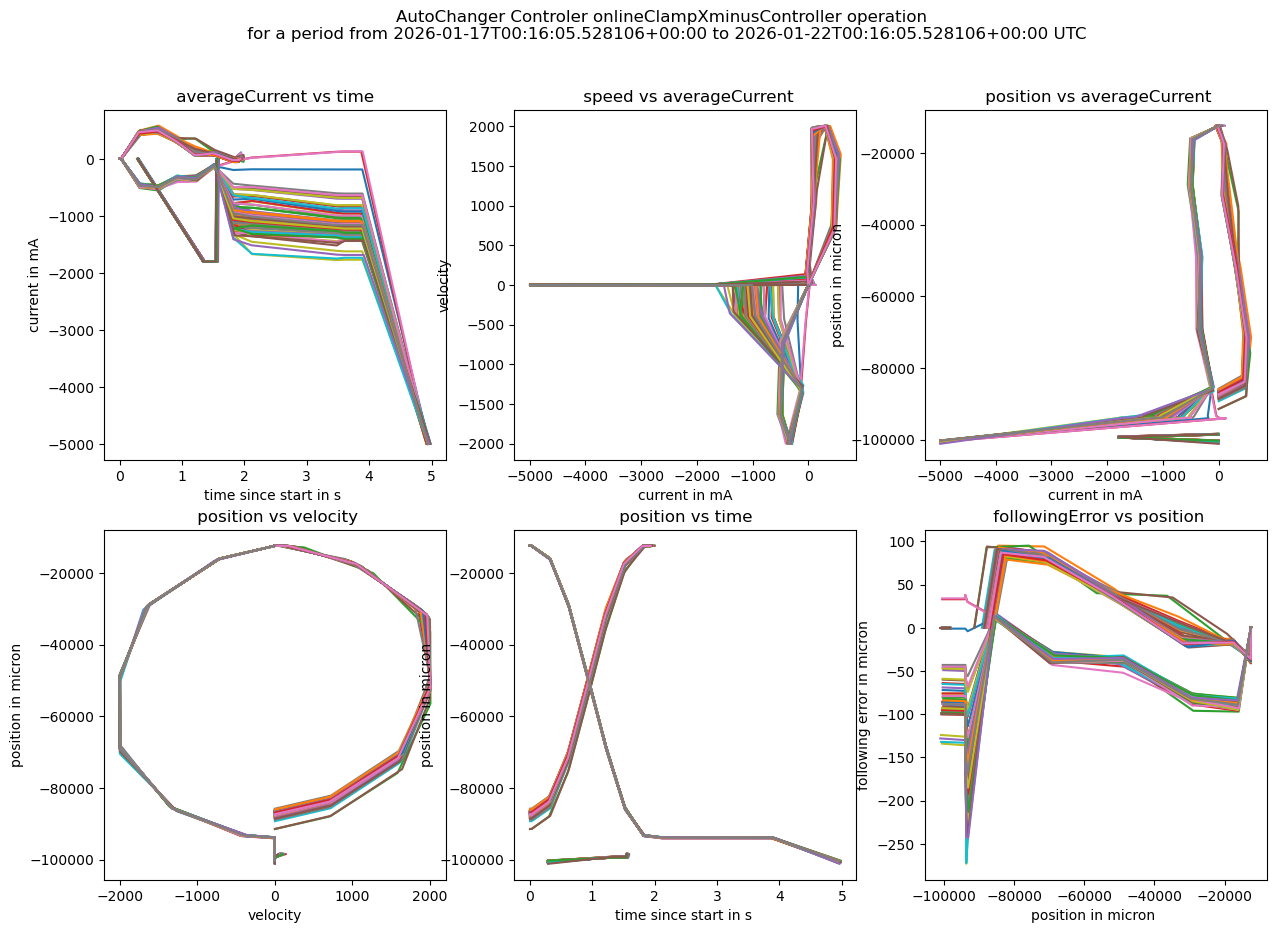


 AutoChanger   onlineClampXplusController 



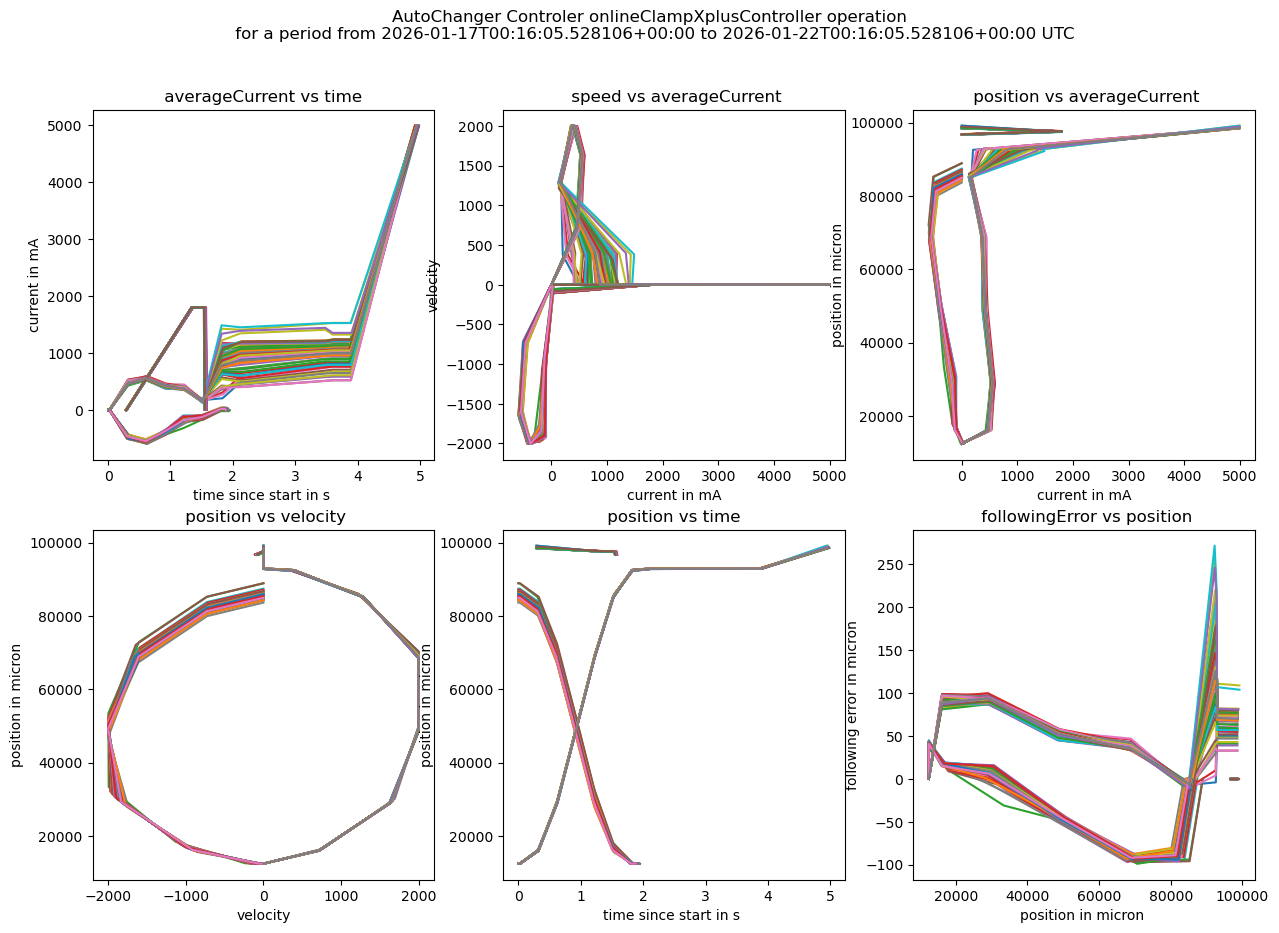


 AutoChanger   onlineClampYminusController 



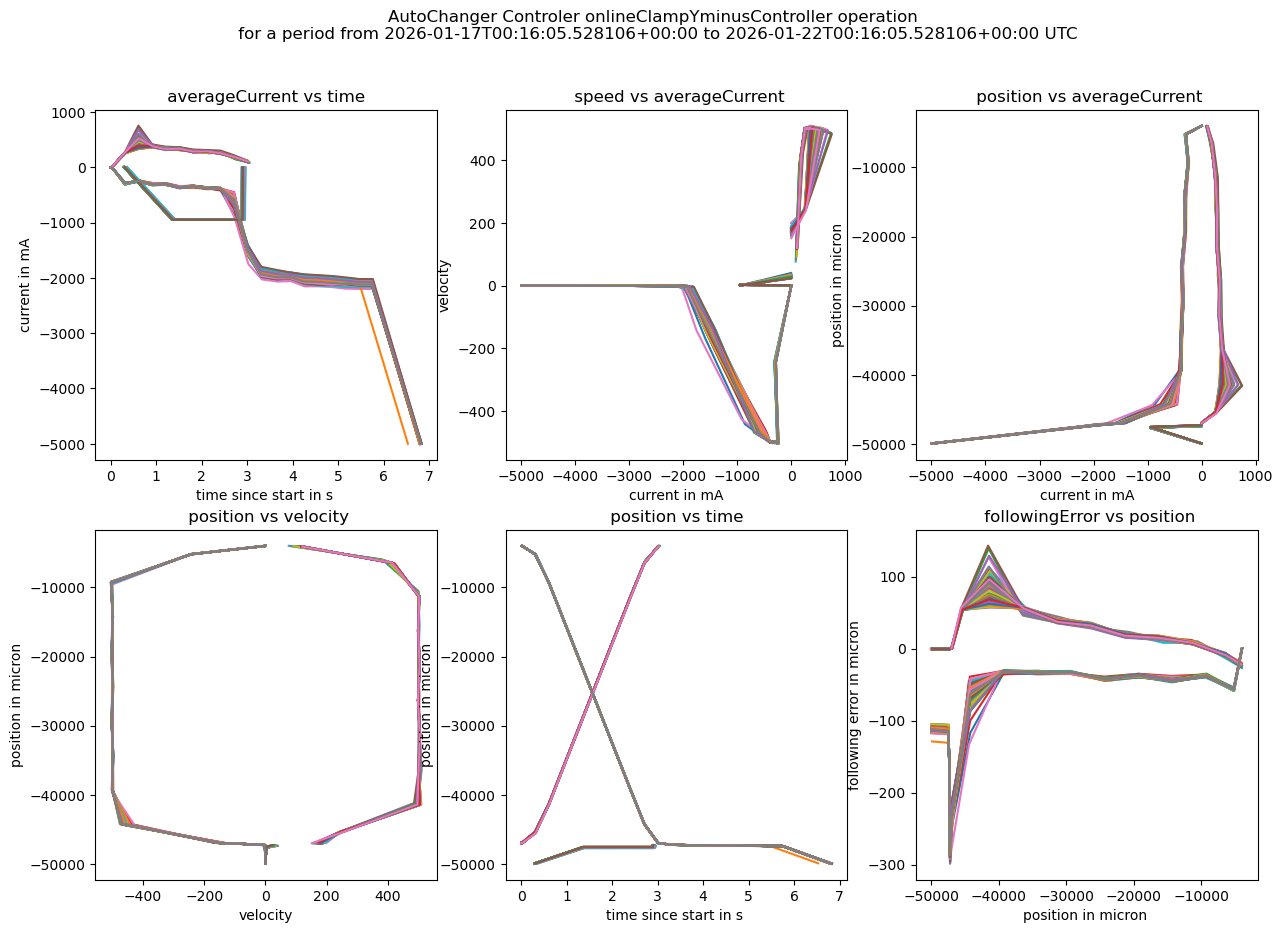


 AutoChanger   latchXminusController 



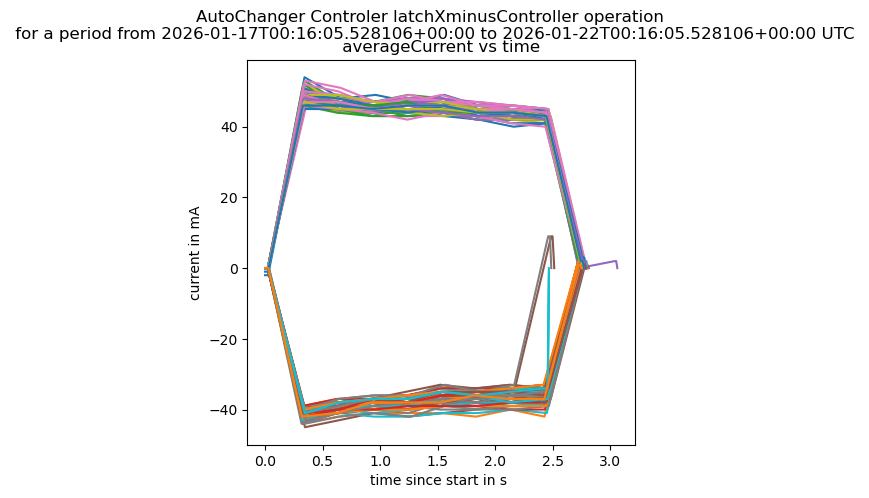


 AutoChanger   latchXplusController 



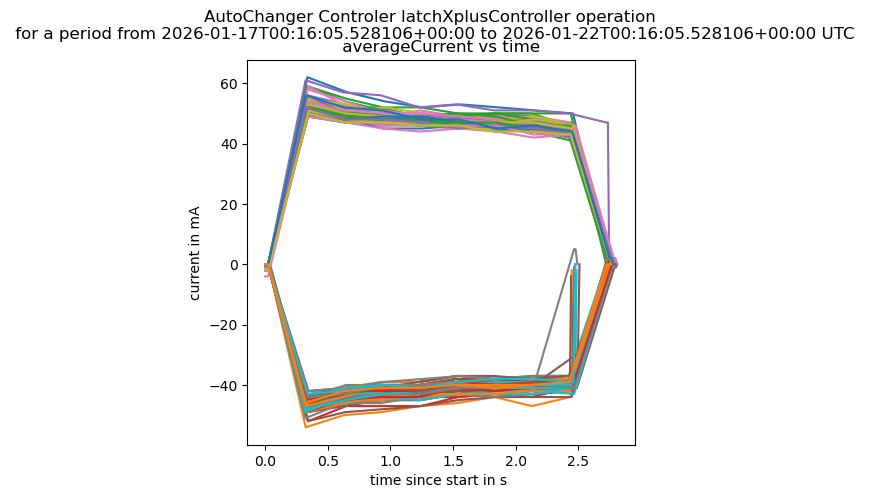


 Carousel   carouselController 



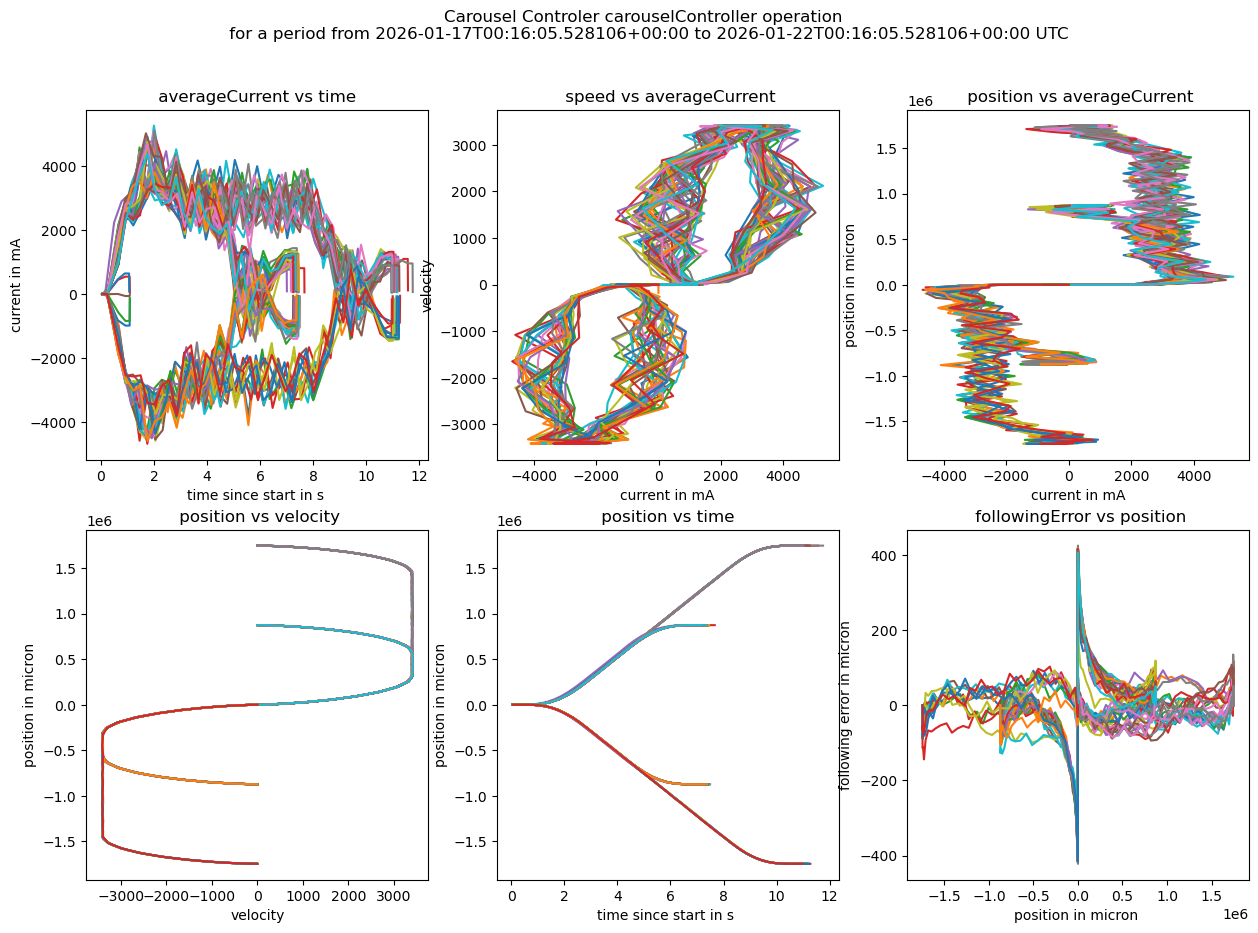


 Carousel   clampXminusController 



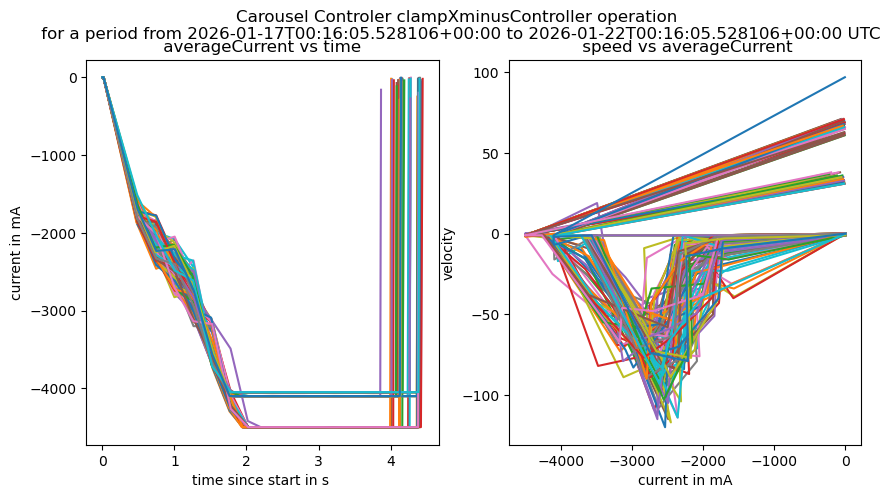


 Carousel   clampXplusController 



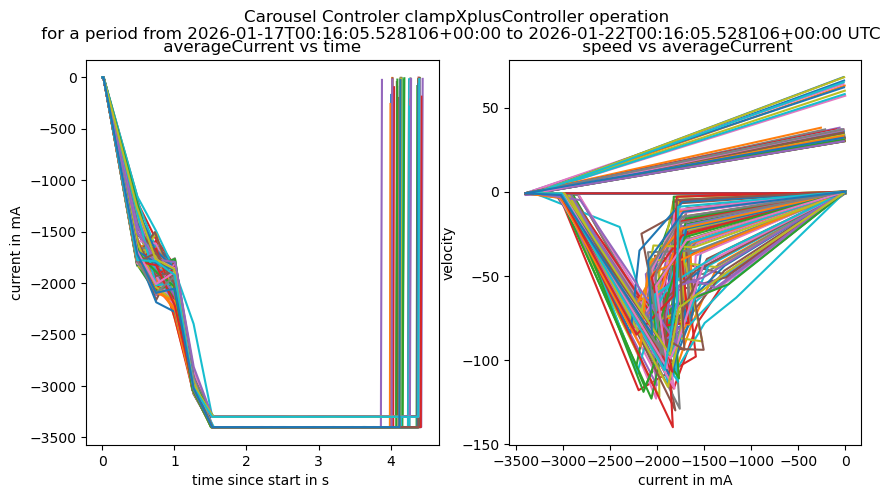

In [15]:
control=['acTruckXminusController','acTruckXplusController','onlineClampXminusController','onlineClampXplusController','onlineClampYminusController','latchXminusController','latchXplusController']
MotorPlot(controler_ac,control,'averageCurrent')
control=['carouselController','clampXminusController','clampXplusController']
MotorPlot(controler_car,control,'averageCurrent')
#MotorPlot(controler_car,control,'current')
